# <center>Курсовая работа Уленгова В.В. </center> 

## Подключение библиотек и скриптов

In [1]:
import numpy as np
import pandas as pd
import random
from datetime import datetime

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler 
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

from lightgbm import LGBMRegressor

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
matplotlib.rcParams.update({'font.size': 14})

import warnings
warnings.filterwarnings('ignore')

In [2]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()
    
def sns_join(feature_1, feature_2):
    grid = sns.jointplot(feature_1, feature_2, kind='reg')
    grid.fig.set_figwidth(12)
    grid.fig.set_figheight(12)

    plt.show()    

In [3]:
def reduce_mem_usage(df):

    start_mem = df.memory_usage().sum() / 1024**2
#    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
#    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
#    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [4]:
class DataPipeline:
    
    def __init__(self):

        self.Rooms_Percent = None
        self.Kitchen_Percent = None
        self.Healthcare_Median = None 
       
    def fit(self, train_df):
        
        self.Rooms_Percent = (train_df['Rooms'] / train_df['Square']).mean() 
        self.Kitchen_Percent = (train_df['KitchenSquare'] / train_df['Square']).mean() 
        self.Healthcare_Median = train_df['Healthcare_1'].median()
            
    def transform(self, train_df):
        
        train_df = reduce_mem_usage(train_df)        
        train_df['Id'] = train_df['Id'].astype('category')
        train_df['DistrictId'] = train_df['DistrictId'].astype('category')
        
        train_df.loc[train_df['Rooms'] == 0, 'Rooms'] = np.nan
        train_df.loc[train_df['Rooms'] >  5, 'Rooms'] = np.nan
        
        train_df.loc[(train_df['Square'] > train_df['LifeSquare'] * 3) & (train_df['LifeSquare'] < 10), 'LifeSquare'] = np.nan        
        train_df.loc[(train_df['LifeSquare'] > train_df['Square'] * 2) & (train_df['Square'] < 10), 'Square'] = train_df['LifeSquare'] + train_df['KitchenSquare']        
        train_df.loc[(train_df['LifeSquare'] > train_df['Square'] * 2), 'LifeSquare'] = np.nan        
        train_df['Square'], train_df['LifeSquare'] = np.where(train_df['Square'] < train_df['LifeSquare'],(train_df['LifeSquare'],train_df['Square']), (train_df['Square'],train_df['LifeSquare']))        
        
        train_df.loc[train_df['Square'] < train_df['KitchenSquare'], 'KitchenSquare'] = np.nan        
        train_df.loc[train_df['Square'] * 0.5 < train_df['KitchenSquare'], 'KitchenSquare'] = np.nan
        
        train_df.loc[train_df['HouseFloor'] > 50, 'HouseFloor'] = train_df['Floor']
        train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] = train_df['Floor']        
        train_df['HouseFloor'], train_df['Floor'] = np.where(train_df['HouseFloor'] < train_df['Floor'],(train_df['Floor'],train_df['HouseFloor']), (train_df['HouseFloor'],train_df['Floor']))        
        
        train_df.loc[train_df['HouseYear'] > datetime.now().year, 'HouseYear'] = train_df['HouseYear'].median()
        
        train_df = pd.concat([train_df, pd.get_dummies(train_df['Ecology_2'])], axis=1)
        train_df.rename(columns={'A': 'Ecology_2_A', 'B': 'Ecology_2_B'}, inplace=True)
        train_df.drop('Ecology_2', axis=1, inplace=True)      
    
        train_df = pd.concat([train_df, pd.get_dummies(train_df['Ecology_3'])], axis=1)
        train_df.rename(columns={'A': 'Ecology_3_A', 'B': 'Ecology_3_B'}, inplace=True)
        train_df.drop('Ecology_3', axis=1, inplace=True)    
    
        train_df = pd.concat([train_df, pd.get_dummies(train_df['Shops_2'])], axis=1)
        train_df.rename(columns={'A': 'Shops_2_A', 'B': 'Shops_2_B'}, inplace=True)
        train_df.drop('Shops_2', axis=1, inplace=True)    
    
        train_df.loc[train_df['Rooms'].isna(), 'Rooms'] = np.round(train_df['Square'] * self.Rooms_Percent)
        train_df.loc[train_df['Rooms'] == 0, 'Rooms'] = 1
        train_df.loc[train_df['Rooms'] >  5, 'Rooms'] = 5    
        
        train_df.loc[train_df['KitchenSquare'].isna(), 'KitchenSquare'] = np.round(train_df['Square'] * self.Kitchen_Percent)        
        
        train_df.loc[train_df['LifeSquare'].isna(), 'LifeSquare'] = train_df['Square'] - train_df['KitchenSquare']
        
        train_df.loc[train_df['Healthcare_1'].isna(), 'Healthcare_1'] = self.Healthcare_Median
     
        feature_names_for_stand = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor','HouseYear', 'Ecology_1', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1', 'Helthcare_2', 'Shops_1']

        district_size = train_df['DistrictId'].value_counts().reset_index().rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
        train_df = train_df.merge(district_size, on='DistrictId', how='left')        
        
        train_df['IsDistrictLarge'] = (train_df['DistrictSize'] > 100).astype(int)

        return train_df


## Описание данных

- Id - идентификационный номер квартиры
- DistrictId - идентификационный номер района
- Rooms - количество комнат
- Square - площадь
- LifeSquare - жилая площадь
- KitchenSquare - площадь кухни
- Floor - этаж
- HouseFloor - количество этажей в доме
- HouseYear - год постройки дома
- Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
- Social_1, Social_2, Social_3 - социальные показатели местности
- Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
- Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
- Price - цена квартиры

## Загрузка данных

In [5]:
train_df = pd.read_csv('train.csv')
train_df = reduce_mem_usage(train_df)
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981560,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.937500
1,15053,41,3.0,65.683640,40.049541,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.437500
2,4765,53,2.0,44.947952,29.197611,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.906250
3,5809,58,2.0,53.352982,52.731510,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.234375
4,10783,99,1.0,39.649193,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531250


In [6]:
train_df.shape[0]

10000

## Распределение целевой переменной

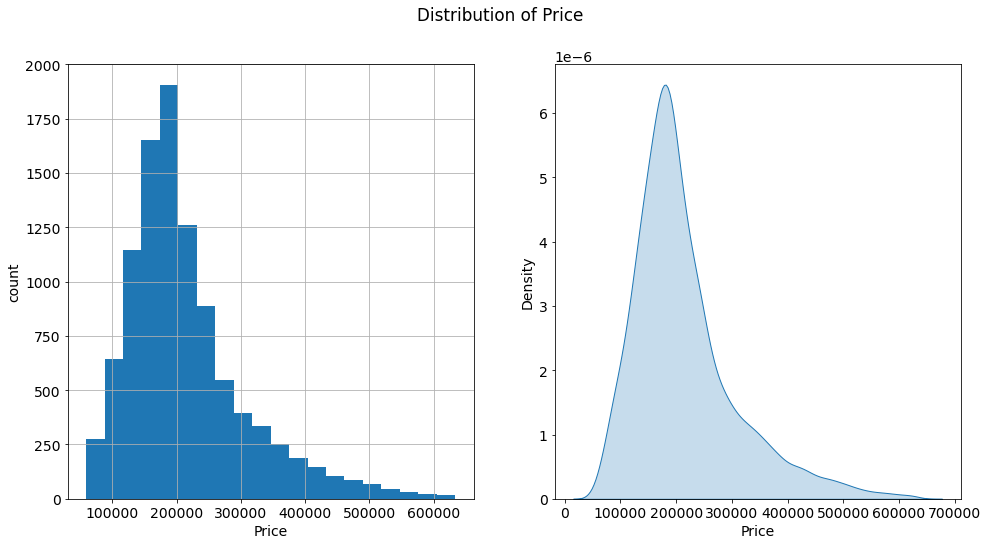

In [7]:
plt.figure(figsize = (16, 8))

plt.subplot(121)
train_df['Price'].hist(density=False, bins=20)
plt.ylabel('count')
plt.xlabel('Price')

plt.subplot(122)
sns.kdeplot(train_df['Price'], shade=True, legend=False)
plt.xlabel('Price')

plt.suptitle('Distribution of Price')
plt.show()

## Анализ признаков

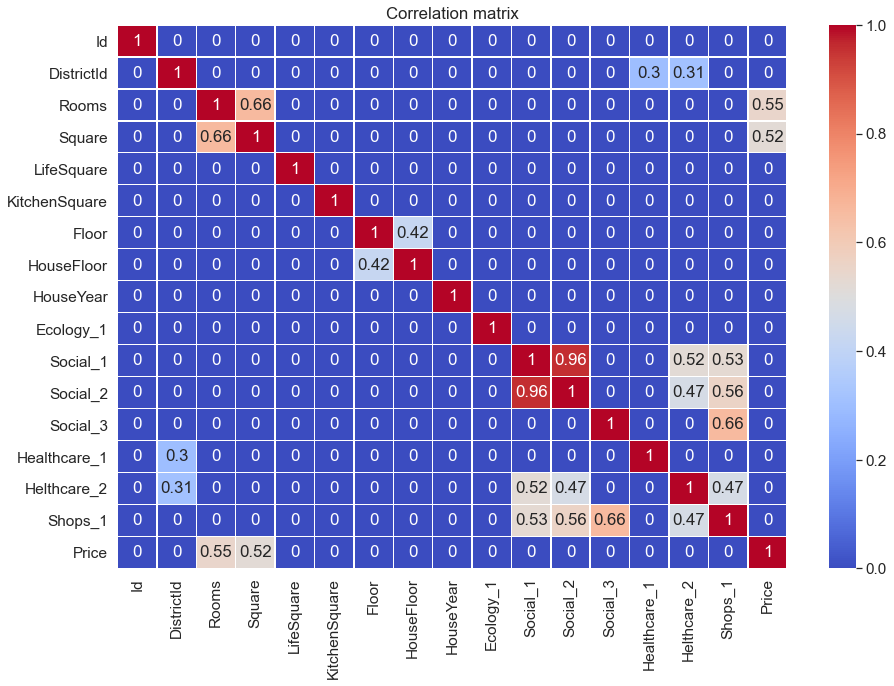

In [8]:
plt.figure(figsize=(15, 10))

sns.set(font_scale=1.4)

corr_matrix = train_df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

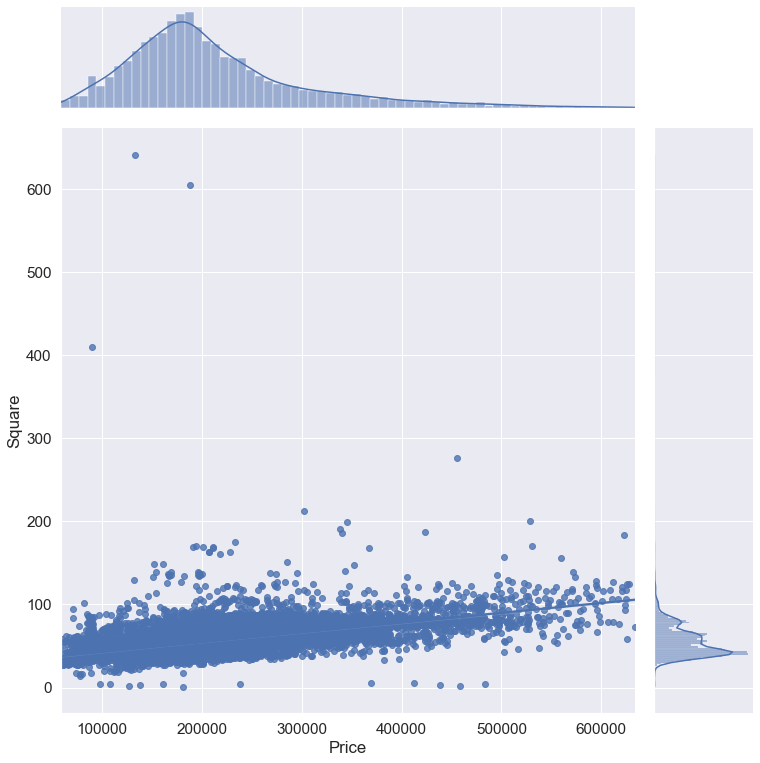

In [9]:
sns_join(train_df['Price'], train_df['Square'])

## Обработка данных

In [10]:
train_df.dtypes

Id                  int16
DistrictId          int16
Rooms             float32
Square            float32
LifeSquare        float32
KitchenSquare     float32
Floor               int16
HouseFloor        float32
HouseYear           int32
Ecology_1         float32
Ecology_2        category
Ecology_3        category
Social_1            int16
Social_2            int16
Social_3            int16
Healthcare_1      float32
Helthcare_2         int16
Shops_1             int16
Shops_2          category
Price             float32
dtype: object

Заменим нечисловые типы на категории

In [11]:
train_df['Id'] = train_df['Id'].astype('category')
train_df['DistrictId'] = train_df['DistrictId'].astype('category')

### Числовые признаки

In [12]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315712,37.199596,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904419,1.319500,4.231300,214139.218750
std,0.839523,21.058718,86.241112,28.561113,5.241148,6.776192,2.005003e+05,0.119026,17.532614,4006.799803,23.831875,1021.518982,1.493601,4.806341,92872.304688
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.777344
25%,1.000000,41.774879,22.769833,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.628906
50%,2.000000,52.513309,32.781261,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.648438
75%,2.000000,65.900627,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.460938
max,19.000000,641.065186,7480.592285,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.437500


#### Число комнат

In [13]:
train_df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

In [14]:
train_df[train_df['Rooms'] == 5]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
1422,4282,195,5.0,95.617531,62.377052,7.0,7,7.0,1940,0.015017,B,B,17,3079,59,2890.0,0,8,B,479525.156250
1503,1243,86,5.0,108.057396,82.723824,8.0,3,5.0,1942,0.161976,B,A,31,7010,5,4508.0,3,7,B,310305.062500
1982,5548,86,5.0,275.645294,233.949310,26.0,12,37.0,2011,0.161976,B,A,31,7010,5,4508.0,3,7,B,455264.875000
3268,8901,34,5.0,121.577423,114.913841,1.0,25,1.0,1977,0.069753,B,B,53,13670,4,NaN,1,11,B,455446.406250
3271,6358,27,5.0,42.003292,NaN,0.0,5,12.0,1977,0.011654,B,B,4,915,0,NaN,0,0,B,112693.640625
4431,7594,53,5.0,39.906082,39.394024,1.0,5,1.0,1977,0.049637,B,B,34,7759,0,229.0,1,3,B,206148.843750
4487,13434,13,5.0,183.382278,100.985504,15.0,2,6.0,1997,0.090799,B,B,74,19083,2,NaN,5,15,B,622888.812500
4762,4070,21,5.0,114.313751,88.492653,9.0,6,5.0,1960,0.034331,B,B,25,5487,3,NaN,0,4,B,499830.937500
5361,2879,78,5.0,118.871948,69.023506,10.0,15,16.0,1998,0.092291,B,B,21,4346,2,165.0,1,2,B,496026.656250
5466,3454,8,5.0,112.135521,79.795448,10.0,4,17.0,1999,0.437885,B,B,23,5735,3,1084.0,0,5,B,471833.781250


Ошибки в данных. Я решил удалить недостоверные данные и пересчитать их потом через площадь квартиры

In [15]:
train_df.loc[train_df['Rooms'] == 0, 'Rooms'] = np.nan
train_df.loc[train_df['Rooms'] >  5, 'Rooms'] = np.nan
train_df['Rooms'].value_counts()

2.0    3880
1.0    3705
3.0    2235
4.0     150
5.0      18
Name: Rooms, dtype: int64

In [16]:
train_df[train_df['Rooms'].isna()].head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
377,5927,57,NaN,59.056976,36.223072,10.0,22,22.0,2002,0.090799,B,B,74,19083,2,NaN,5,15,B,317265.312500
1397,12638,27,NaN,138.427689,136.215500,0.0,4,3.0,2016,0.075424,B,B,11,3097,0,NaN,0,0,B,268394.750000
1454,8491,1,NaN,42.006046,21.779287,7.0,17,17.0,2014,0.007122,B,B,1,264,0,NaN,0,1,B,78364.617188
1981,7917,27,NaN,212.932358,211.231125,0.0,2,3.0,2008,0.211401,B,B,9,1892,0,NaN,0,1,B,302211.250000
2170,14003,99,NaN,59.414333,38.702244,6.0,7,9.0,1969,0.033494,B,B,66,10573,1,1322.0,3,8,B,229661.968750


#### Общая и жилая площадь

In [17]:
train_df[(train_df['Square'] > train_df['LifeSquare'] * 3) & (train_df['LifeSquare'] < 10) ]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
26,4378,27,3.0,106.958870,0.641822,0.0,17,0.0,2018,0.072158,B,B,2,629,1,NaN,0,0,A,337299.875000
95,4280,34,2.0,61.334969,4.091945,1.0,26,1.0,2014,0.069753,B,B,53,13670,4,NaN,1,11,B,286564.437500
134,12613,6,2.0,65.496674,5.589324,1.0,5,17.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,180727.640625
158,16779,27,3.0,51.991066,4.896202,1.0,22,25.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,174687.562500
160,3522,6,1.0,66.419838,3.987101,1.0,2,1.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,193361.234375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9756,13583,27,2.0,58.943039,3.319486,1.0,11,17.0,2017,0.011654,B,B,4,915,0,NaN,0,0,B,142789.953125
9813,2040,62,1.0,122.438148,5.751401,1.0,2,3.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,224900.890625
9828,13630,24,3.0,127.141144,4.811405,1.0,3,1.0,2017,0.111627,B,B,50,12238,8,1970.0,2,3,B,611250.937500
9888,6053,6,1.0,41.314774,5.005477,1.0,9,17.0,2016,0.243205,B,B,5,1564,0,540.0,0,0,B,159149.515625


In [18]:
train_df.loc[(train_df['Square'] > train_df['LifeSquare'] * 3) & (train_df['LifeSquare'] < 10), 'LifeSquare'] = np.nan

In [19]:
train_df[(train_df['LifeSquare'] > train_df['Square'] * 2) & (train_df['Square'] < 10)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
212,1748,88,2.0,5.497061,67.628716,1.0,24,22.0,1977,0.127376,B,B,43,8429,3,NaN,3,9,B,412511.093750
3280,10527,27,1.0,4.380726,40.805836,1.0,10,17.0,2013,0.211401,B,B,9,1892,0,NaN,0,1,B,97560.718750
6392,14786,1,1.0,1.136859,4.525736,1.0,3,1.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,181434.828125
8030,13265,1,3.0,4.823679,79.767967,0.0,6,17.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,237716.687500


In [20]:
train_df.loc[(train_df['LifeSquare'] > train_df['Square'] * 2) & (train_df['Square'] < 10), 'Square'] = train_df['LifeSquare'] + train_df['KitchenSquare']

In [21]:
train_df[(train_df['LifeSquare'] > train_df['Square'] * 2)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
590,14990,23,2.0,48.449875,263.542023,5.0,6,5.0,1972,0.075779,B,B,6,1437,3,NaN,0,2,B,141780.234375
4328,16550,27,3.0,81.694420,7480.592285,1.0,9,17.0,2016,0.017647,B,B,2,469,0,NaN,0,0,B,217357.500000
6332,8961,27,1.0,33.398983,164.153366,6.0,3,5.0,1965,0.211401,B,B,9,1892,0,NaN,0,1,B,104891.070312
8437,15886,85,3.0,78.059334,461.463623,10.0,12,16.0,1998,0.037178,B,B,52,11217,1,2300.0,1,7,B,394253.312500


In [22]:
train_df.loc[(train_df['LifeSquare'] > train_df['Square'] * 2), 'LifeSquare'] = np.nan
train_df[train_df['LifeSquare'].isna()].head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
7,11993,74,2.0,80.312927,NaN,0.0,14,0.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,221244.156250
8,5172,1,2.0,64.511436,NaN,1.0,9,17.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,229102.796875
21,11935,27,2.0,64.711838,NaN,1.0,15,1.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,127200.023438
23,6641,54,3.0,118.907608,NaN,0.0,2,0.0,1977,0.006076,B,B,30,5285,0,645.0,6,6,B,571069.062500
25,5073,74,2.0,82.667915,NaN,1.0,16,17.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,244145.828125


In [23]:
train_df[(train_df['LifeSquare'] > train_df['Square'])]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
28,8054,23,1.0,42.530045,43.967758,1.0,3,9.0,2014,0.034656,B,B,0,168,0,NaN,0,0,B,95338.195312
44,10521,38,3.0,104.211395,106.340401,0.0,20,0.0,2017,0.060753,B,B,15,2787,2,520.0,0,7,B,435462.062500
52,2301,1,2.0,61.400055,65.224602,0.0,17,22.0,2016,0.007122,B,B,1,264,0,NaN,0,1,B,199215.453125
123,8753,25,3.0,85.952309,89.803749,1.0,4,3.0,2017,0.069753,B,B,53,13670,4,NaN,1,11,B,309688.593750
153,9870,62,1.0,51.831474,53.491302,1.0,5,1.0,2015,0.072158,B,B,2,629,1,NaN,0,0,A,131797.468750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9884,41,30,2.0,59.015896,59.439083,12.0,5,5.0,2016,0.000078,B,B,22,6398,141,1046.0,3,23,B,126281.140625
9889,12918,23,2.0,51.440464,53.134243,51.0,3,17.0,2017,0.005767,B,B,1,388,0,NaN,0,0,B,88150.015625
9895,2737,27,3.0,123.430069,125.806984,123.0,5,10.0,2015,0.017647,B,B,2,469,0,NaN,0,0,B,234194.843750
9902,14001,73,1.0,44.098766,44.267551,1.0,7,24.0,2014,0.042032,B,B,37,6856,84,1940.0,2,5,B,381937.406250


Поменяем местами

In [24]:
train_df['Square'], train_df['LifeSquare'] = np.where(train_df['Square'] < train_df['LifeSquare'],(train_df['LifeSquare'],train_df['Square']), (train_df['Square'],train_df['LifeSquare']))
(train_df['Square'] < train_df['LifeSquare']).value_counts()

False    10000
dtype: int64

### Площадь кухни

In [25]:
train_df['KitchenSquare'].value_counts()

1.0       2460
8.0       1306
5.0       1169
10.0      1075
6.0       1038
9.0        843
0.0        697
7.0        609
12.0       249
11.0       233
13.0        67
14.0        51
4.0         39
15.0        31
3.0         22
16.0        16
20.0        14
17.0        12
19.0        11
18.0         6
2.0          4
22.0         3
41.0         2
112.0        2
25.0         2
43.0         2
51.0         2
37.0         2
32.0         2
30.0         2
58.0         2
72.0         1
96.0         1
66.0         1
48.0         1
40.0         1
2014.0       1
35.0         1
60.0         1
78.0         1
27.0         1
84.0         1
62.0         1
42.0         1
63.0         1
39.0         1
1970.0       1
36.0         1
75.0         1
26.0         1
21.0         1
29.0         1
23.0         1
73.0         1
123.0        1
31.0         1
53.0         1
54.0         1
Name: KitchenSquare, dtype: int64

Аномалии

In [26]:
train_df[train_df['Square'] < train_df['KitchenSquare']]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
1064,14656,62,1.0,47.100719,46.447960,2014.0,4,1.0,2014,0.072158,B,B,2,629,1,NaN,0,0,A,108337.484375
5149,13703,42,1.0,38.071693,19.723547,73.0,9,10.0,2006,0.158249,B,B,21,5731,0,NaN,1,0,B,160488.031250
7088,6569,27,1.0,38.220257,18.716856,84.0,4,17.0,2018,0.011654,B,B,4,915,0,NaN,0,0,B,99079.960938
8584,14679,81,1.0,32.276665,19.278395,1970.0,6,1.0,1977,0.006076,B,B,30,5285,0,645.0,6,6,B,105539.554688


In [27]:
train_df.loc[train_df['Square'] < train_df['KitchenSquare'], 'KitchenSquare'] = np.nan

In [28]:
train_df[train_df['Square'] *0.5 < train_df['KitchenSquare']]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
227,16395,2,3.0,79.722244,44.731220,72.0,12,16.0,1987,0.130618,B,B,39,10418,9,900.0,1,9,B,370148.625000
551,1315,6,1.0,48.128113,45.023533,48.0,21,1.0,2013,0.243205,B,B,5,1564,0,540.0,0,0,B,146950.906250
1077,9690,27,1.0,40.081043,37.834965,37.0,18,19.0,2019,0.211401,B,B,9,1892,0,NaN,0,1,B,93218.648438
1369,2371,27,2.0,68.841072,64.234955,66.0,4,2.0,2014,0.017647,B,B,2,469,0,NaN,0,0,B,189244.250000
1455,12507,54,2.0,79.810532,79.578964,78.0,10,15.0,2014,0.006076,B,B,30,5285,0,645.0,6,6,B,438708.718750
1860,4265,161,2.0,53.216778,32.644859,53.0,7,17.0,1994,0.000699,B,B,14,3369,24,4129.0,0,3,B,261125.671875
2916,12390,72,3.0,99.323555,97.490677,96.0,22,25.0,2019,0.210473,B,B,11,2398,2,1994.0,3,0,B,445074.968750
2969,7441,62,3.0,114.734474,112.589081,112.0,3,3.0,2015,0.072158,B,B,2,629,1,NaN,0,0,A,315245.531250
3379,16781,27,1.0,36.710541,36.138409,36.0,19,19.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A,131742.531250
4079,6508,23,2.0,67.146049,33.959152,63.0,5,17.0,2019,0.034656,B,B,0,168,0,NaN,0,0,B,193130.578125


In [29]:
train_df.loc[train_df['Square'] * 0.5 < train_df['KitchenSquare'], 'KitchenSquare'] = np.nan

In [30]:
train_df[train_df['KitchenSquare'].isna()]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
227,16395,2,3.0,79.722244,44.731220,NaN,12,16.0,1987,0.130618,B,B,39,10418,9,900.0,1,9,B,370148.625000
551,1315,6,1.0,48.128113,45.023533,NaN,21,1.0,2013,0.243205,B,B,5,1564,0,540.0,0,0,B,146950.906250
1064,14656,62,1.0,47.100719,46.447960,NaN,4,1.0,2014,0.072158,B,B,2,629,1,NaN,0,0,A,108337.484375
1077,9690,27,1.0,40.081043,37.834965,NaN,18,19.0,2019,0.211401,B,B,9,1892,0,NaN,0,1,B,93218.648438
1369,2371,27,2.0,68.841072,64.234955,NaN,4,2.0,2014,0.017647,B,B,2,469,0,NaN,0,0,B,189244.250000
1455,12507,54,2.0,79.810532,79.578964,NaN,10,15.0,2014,0.006076,B,B,30,5285,0,645.0,6,6,B,438708.718750
1860,4265,161,2.0,53.216778,32.644859,NaN,7,17.0,1994,0.000699,B,B,14,3369,24,4129.0,0,3,B,261125.671875
2916,12390,72,3.0,99.323555,97.490677,NaN,22,25.0,2019,0.210473,B,B,11,2398,2,1994.0,3,0,B,445074.968750
2969,7441,62,3.0,114.734474,112.589081,NaN,3,3.0,2015,0.072158,B,B,2,629,1,NaN,0,0,A,315245.531250
3379,16781,27,1.0,36.710541,36.138409,NaN,19,19.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A,131742.531250


#### Этаж, Этажность

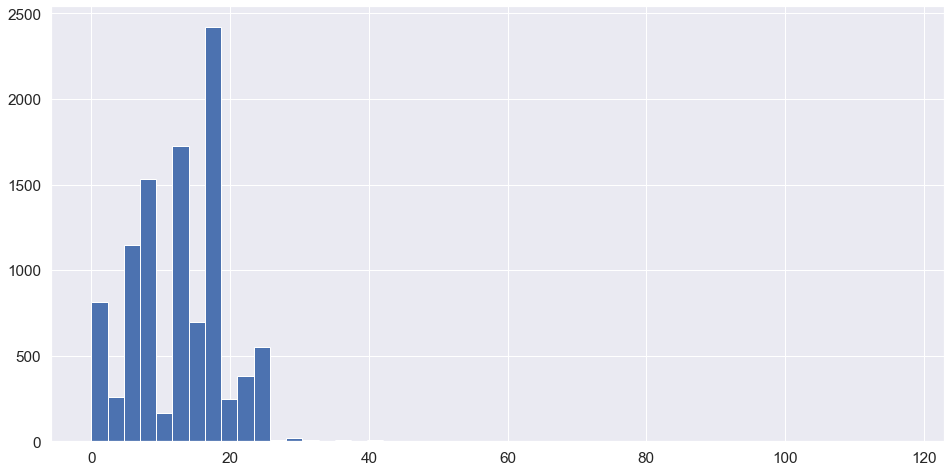

In [31]:
plt.figure(figsize = (16, 8))
train_df['HouseFloor'].hist(bins=50)
plt.show()

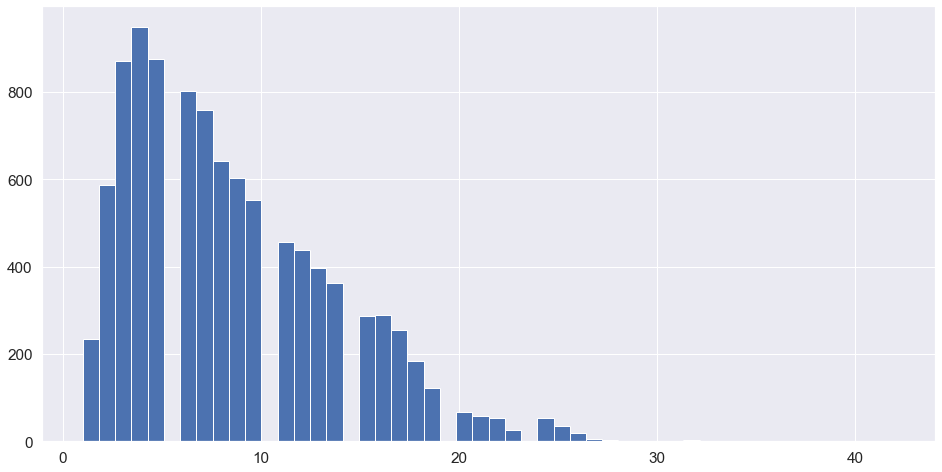

In [32]:
plt.figure(figsize = (16, 8))
train_df['Floor'].hist(bins=50)
plt.show()

Аномалии

In [33]:
train_df[train_df['HouseFloor'] > 50]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
6131,10806,5,1.0,51.944588,48.709602,1.0,6,99.0,1977,0.150818,B,B,16,3433,4,2643.0,4,5,B,296127.12500
8599,9300,74,2.0,74.579811,71.747871,9.0,5,99.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,243329.90625
8854,78,30,2.0,66.811790,65.773750,1.0,8,117.0,1977,0.000078,B,B,22,6398,141,1046.0,3,23,B,207248.37500


In [34]:
train_df.loc[train_df['HouseFloor'] > 50, 'HouseFloor'] = train_df['Floor']
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] = train_df['Floor']

In [35]:
train_df[train_df['Floor'] > train_df['HouseFloor']]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
14,10953,27,1.0,53.769096,52.408028,1.0,5,4.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,140647.562500
16,2119,27,2.0,49.360649,31.993963,5.0,6,5.0,1983,0.051815,B,B,5,1227,0,NaN,0,0,B,117000.382812
21,11935,27,2.0,64.711838,NaN,1.0,15,1.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,127200.023438
35,6486,200,3.0,85.280388,58.447968,9.0,6,5.0,1960,0.000000,B,B,33,7425,1,NaN,2,5,B,402871.906250
51,10103,94,1.0,35.280895,23.354176,6.0,11,9.0,1971,0.282798,B,B,33,8667,2,NaN,0,6,B,148862.203125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9984,2237,52,3.0,64.074974,47.633427,6.0,11,9.0,1983,0.371149,B,B,34,7065,1,750.0,2,5,B,226434.875000
9985,16159,27,1.0,38.968338,NaN,1.0,10,1.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,95529.570312
9989,4145,96,3.0,90.055229,47.860229,11.0,26,24.0,2005,0.041116,B,B,53,14892,4,NaN,1,4,B,441108.906250
9991,11553,3,3.0,101.622795,51.628780,12.0,18,17.0,2000,0.265089,B,B,37,5288,0,1937.0,3,2,B,212883.500000


Поменяем местами

In [36]:
train_df['HouseFloor'], train_df['Floor'] = np.where(train_df['HouseFloor'] < train_df['Floor'],(train_df['Floor'],train_df['HouseFloor']), (train_df['HouseFloor'],train_df['Floor']))
(train_df['HouseFloor'] < train_df['Floor']).value_counts()

False    10000
dtype: int64

#### Год постойки

In [37]:
train_df['HouseYear'].sort_values(ascending=False)

1497    20052011
4189        4968
1499        2020
5701        2020
7076        2020
          ...   
7611        1916
910         1914
5111        1912
2656        1912
9317        1910
Name: HouseYear, Length: 10000, dtype: int32

In [38]:
train_df.loc[train_df['HouseYear'] > datetime.now().year, 'HouseYear'] = train_df['HouseYear'].median()
train_df['HouseYear'].sort_values(ascending=False)

9674    2020
4493    2020
6735    2020
4376    2020
7076    2020
        ... 
7611    1916
910     1914
5111    1912
2656    1912
9317    1910
Name: HouseYear, Length: 10000, dtype: int32

#### Ecology_1

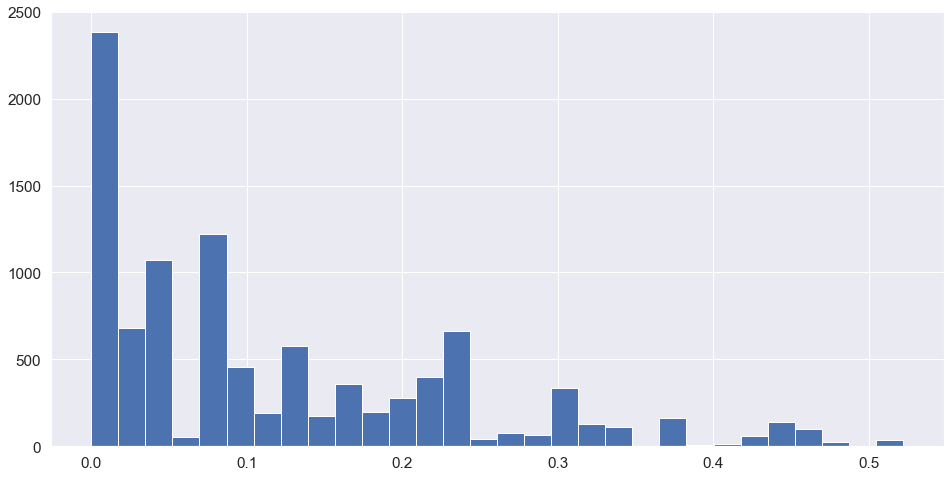

In [39]:
plt.figure(figsize = (16, 8))
train_df['Ecology_1'].hist(bins=30)
plt.show()

#### Social_1

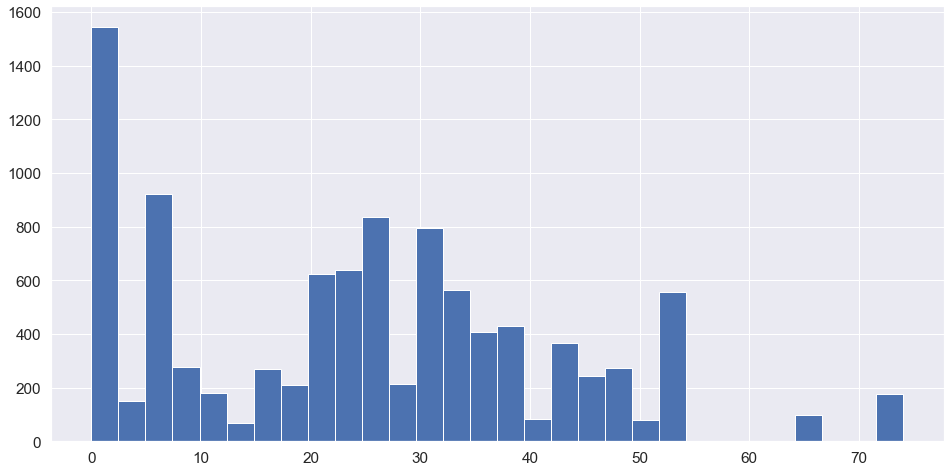

In [40]:
plt.figure(figsize = (16, 8))
train_df['Social_1'].hist(bins=30)
plt.show()

#### Social_2

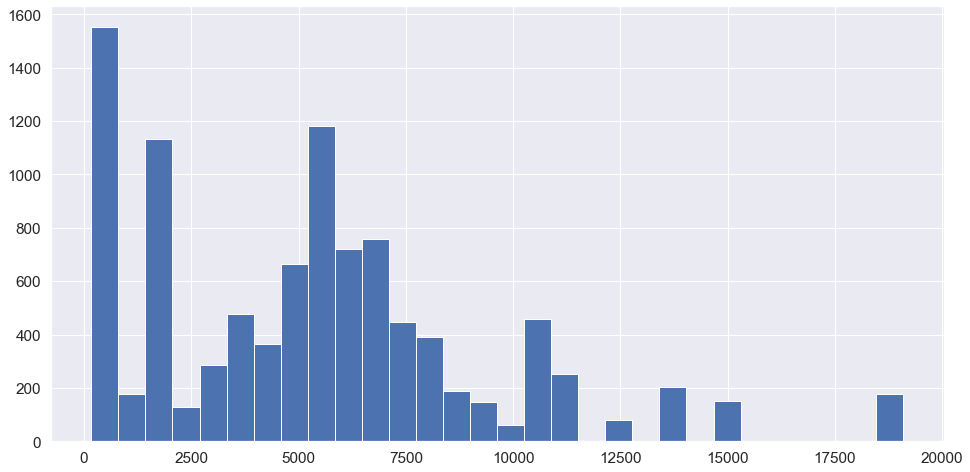

In [41]:
plt.figure(figsize = (16, 8))
train_df['Social_2'].hist(bins=30)
plt.show()

#### Social_3

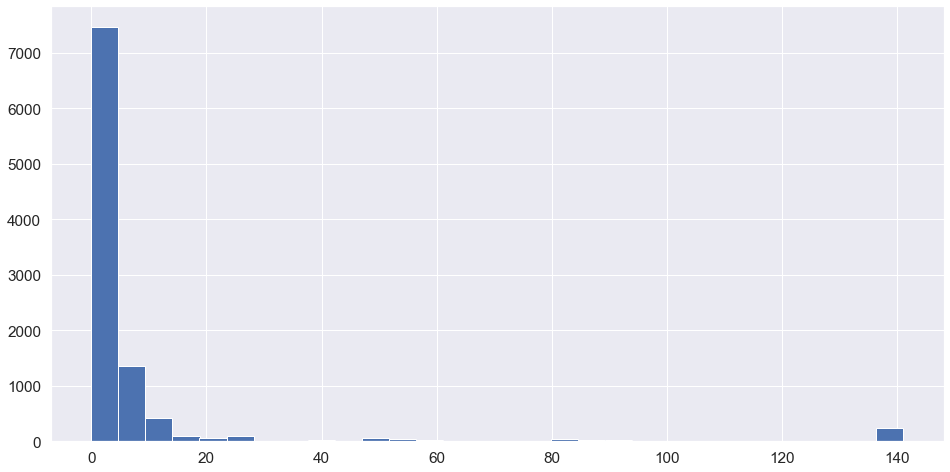

In [42]:
plt.figure(figsize = (16, 8))
train_df['Social_3'].hist(bins=30)
plt.show()

#### Healthcare_1

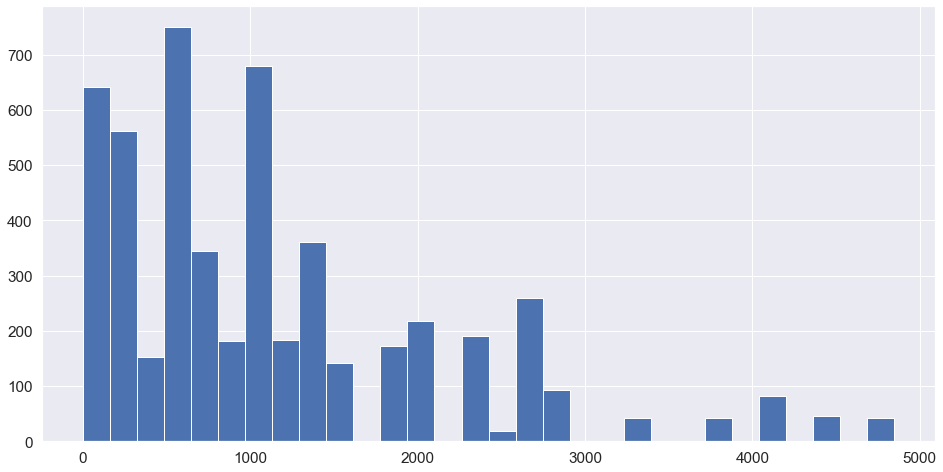

In [43]:
plt.figure(figsize = (16, 8))
train_df['Healthcare_1'].hist(bins=30)
plt.show()

#### Helthcare_2

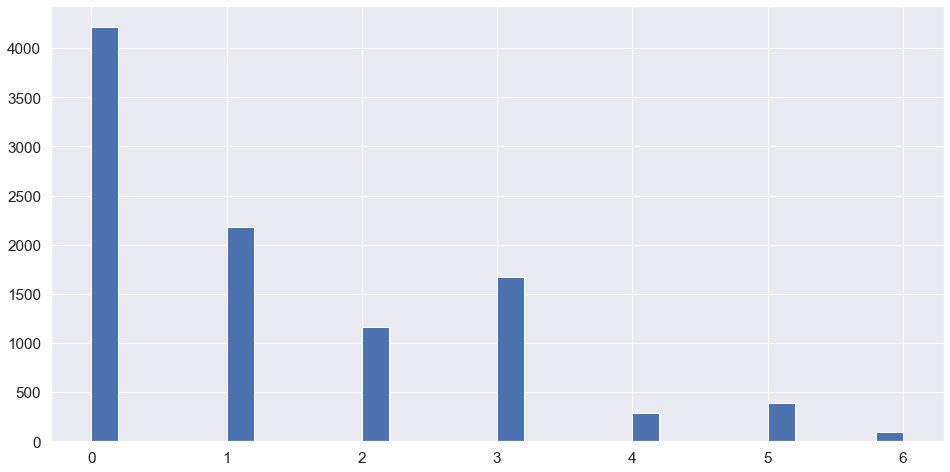

In [44]:
plt.figure(figsize = (16, 8))
train_df['Helthcare_2'].hist(bins=30)
plt.show()

#### Shops_1

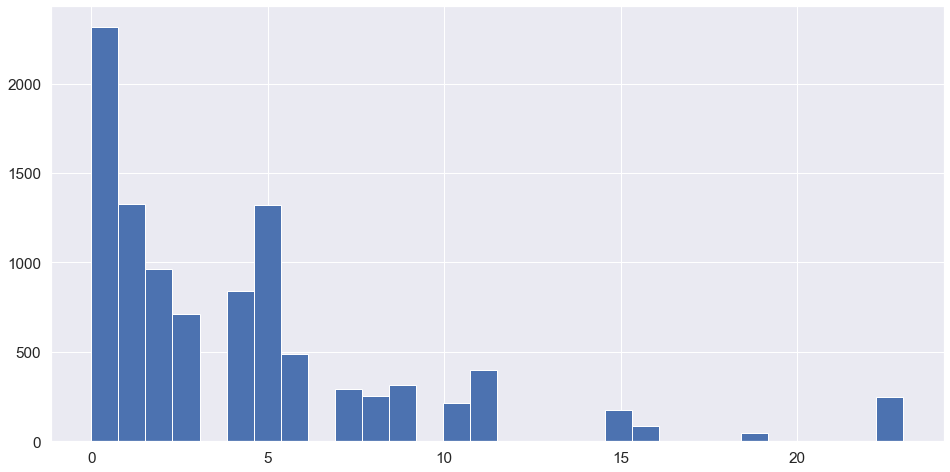

In [45]:
plt.figure(figsize = (16, 8))
train_df['Shops_1'].hist(bins=30)
plt.show()

In [46]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,9988.000000,10000.000000,7688.000000,9969.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.888266,56.410892,36.886181,5.71281,7.943200,13.406100,1984.863800,0.118858,24.687000,5352.157400,8.039200,1142.904419,1.319500,4.231300,214139.218750
std,0.811548,21.054884,18.886993,4.00030,5.228094,5.883285,18.409979,0.119026,17.532614,4006.799803,23.831875,1021.518982,1.493601,4.806341,92872.304688
min,1.000000,2.377248,0.873147,0.00000,1.000000,1.000000,1910.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.777344
25%,1.000000,41.865869,23.266581,1.00000,4.000000,9.000000,1974.000000,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.628906
50%,2.000000,52.619610,33.082787,6.00000,7.000000,14.000000,1977.000000,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.648438
75%,2.000000,65.990473,45.270760,9.00000,11.000000,17.000000,2001.000000,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.460938
max,5.000000,641.065186,638.163208,43.00000,42.000000,48.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.437500


### Категориальные признаки

In [47]:
train_df.select_dtypes(include='category').columns.tolist()

['Id', 'DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']

#### Район. Ничего не далаем

In [48]:
train_df['DistrictId'].value_counts()

27     851
1      652
23     565
6      511
9      294
      ... 
199      1
117      1
205      1
207      1
209      1
Name: DistrictId, Length: 205, dtype: int64

#### Ecology_2. Разобьем на бинарные

In [49]:
train_df['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [50]:
train_df = pd.concat([train_df, pd.get_dummies(train_df['Ecology_2'])], axis=1)
train_df.rename(columns={'A': 'Ecology_2_A', 'B': 'Ecology_2_B'}, inplace=True)
train_df.drop('Ecology_2', axis=1, inplace=True)
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_A,Ecology_2_B
0,14038,35,2.0,47.981560,29.442751,6.0,7.0,9.0,1969,0.089040,...,33,7976,5,NaN,0,11,B,184966.937500,0,1
1,15053,41,3.0,65.683640,40.049541,8.0,7.0,9.0,1978,0.000070,...,46,10309,1,240.0,1,16,B,300009.437500,0,1
2,4765,53,2.0,44.947952,29.197611,0.0,8.0,12.0,1968,0.049637,...,34,7759,0,229.0,1,3,B,220925.906250,0,1
3,5809,58,2.0,53.352982,52.731510,9.0,8.0,17.0,1977,0.437885,...,23,5735,3,1084.0,0,5,B,175616.234375,0,1
4,10783,99,1.0,39.649193,23.776169,7.0,11.0,12.0,1976,0.012339,...,35,5776,1,2078.0,2,4,B,150226.531250,0,1


#### Ecology_3. Разобьем на бинарные

In [51]:
train_df['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [52]:
train_df = pd.concat([train_df, pd.get_dummies(train_df['Ecology_3'])], axis=1)
train_df.rename(columns={'A': 'Ecology_3_A', 'B': 'Ecology_3_B'}, inplace=True)
train_df.drop('Ecology_3', axis=1, inplace=True)
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B
0,14038,35,2.0,47.981560,29.442751,6.0,7.0,9.0,1969,0.089040,...,5,NaN,0,11,B,184966.937500,0,1,0,1
1,15053,41,3.0,65.683640,40.049541,8.0,7.0,9.0,1978,0.000070,...,1,240.0,1,16,B,300009.437500,0,1,0,1
2,4765,53,2.0,44.947952,29.197611,0.0,8.0,12.0,1968,0.049637,...,0,229.0,1,3,B,220925.906250,0,1,0,1
3,5809,58,2.0,53.352982,52.731510,9.0,8.0,17.0,1977,0.437885,...,3,1084.0,0,5,B,175616.234375,0,1,0,1
4,10783,99,1.0,39.649193,23.776169,7.0,11.0,12.0,1976,0.012339,...,1,2078.0,2,4,B,150226.531250,0,1,0,1


#### Shops_2. Разобьем на бинарные

In [53]:
train_df['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

In [54]:
train_df = pd.concat([train_df, pd.get_dummies(train_df['Shops_2'])], axis=1)
train_df.rename(columns={'A': 'Shops_2_A', 'B': 'Shops_2_B'}, inplace=True)
train_df.drop('Shops_2', axis=1, inplace=True)
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
0,14038,35,2.0,47.981560,29.442751,6.0,7.0,9.0,1969,0.089040,...,NaN,0,11,184966.937500,0,1,0,1,0,1
1,15053,41,3.0,65.683640,40.049541,8.0,7.0,9.0,1978,0.000070,...,240.0,1,16,300009.437500,0,1,0,1,0,1
2,4765,53,2.0,44.947952,29.197611,0.0,8.0,12.0,1968,0.049637,...,229.0,1,3,220925.906250,0,1,0,1,0,1
3,5809,58,2.0,53.352982,52.731510,9.0,8.0,17.0,1977,0.437885,...,1084.0,0,5,175616.234375,0,1,0,1,0,1
4,10783,99,1.0,39.649193,23.776169,7.0,11.0,12.0,1976,0.012339,...,2078.0,2,4,150226.531250,0,1,0,1,0,1


### Обработка пропусков

In [55]:
train_df.isna().sum()

Id                  0
DistrictId          0
Rooms              12
Square              0
LifeSquare       2312
KitchenSquare      31
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Price               0
Ecology_2_A         0
Ecology_2_B         0
Ecology_3_A         0
Ecology_3_B         0
Shops_2_A           0
Shops_2_B           0
dtype: int64

#### Rooms

In [56]:
Rooms_Percent =  (train_df['Rooms'] / train_df['Square']).mean() 
Rooms_Percent

0.033459097146987915

In [57]:
train_df.loc[train_df['Rooms'].isna(), 'Rooms'] = np.round(train_df['Square'] * Rooms_Percent)
train_df.loc[train_df['Rooms'] == 0, 'Rooms'] = 1
train_df.loc[train_df['Rooms'] >  5, 'Rooms'] = 5
train_df['Rooms'].value_counts()

2.0    3884
1.0    3709
3.0    2237
4.0     150
5.0      20
Name: Rooms, dtype: int64

#### KitchenSquare

In [58]:
Kitchen_Percent =  (train_df['KitchenSquare'] / train_df['Square']).mean() 
Kitchen_Percent

0.11000772565603256

In [59]:
train_df.loc[train_df['KitchenSquare'].isna(), 'KitchenSquare'] = np.round(train_df['Square'] * Kitchen_Percent)

#### LifeSquare

In [60]:
train_df.loc[train_df['LifeSquare'].isna(), 'LifeSquare'] = train_df['Square'] - train_df['KitchenSquare']

#### Healthcare_1

In [61]:
train_df.loc[train_df['Healthcare_1'].isna(), 'Healthcare_1'] = train_df['Healthcare_1'].median()
train_df['Healthcare_1'].value_counts()

900.0     4869
540.0      511
30.0       348
1046.0     245
750.0      163
          ... 
370.0       14
32.0        12
1815.0      10
35.0         2
0.0          1
Name: Healthcare_1, Length: 79, dtype: int64

In [62]:
train_df.isna().sum()

Id               0
DistrictId       0
Rooms            0
Square           0
LifeSquare       0
KitchenSquare    0
Floor            0
HouseFloor       0
HouseYear        0
Ecology_1        0
Social_1         0
Social_2         0
Social_3         0
Healthcare_1     0
Helthcare_2      0
Shops_1          0
Price            0
Ecology_2_A      0
Ecology_2_B      0
Ecology_3_A      0
Ecology_3_B      0
Shops_2_A        0
Shops_2_B        0
dtype: int64

In [63]:
train_df.head(1000)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
0,14038,35,2.0,47.981560,29.442751,6.0,7.0,9.0,1969,0.089040,...,900.0,0,11,184966.937500,0,1,0,1,0,1
1,15053,41,3.0,65.683640,40.049541,8.0,7.0,9.0,1978,0.000070,...,240.0,1,16,300009.437500,0,1,0,1,0,1
2,4765,53,2.0,44.947952,29.197611,0.0,8.0,12.0,1968,0.049637,...,229.0,1,3,220925.906250,0,1,0,1,0,1
3,5809,58,2.0,53.352982,52.731510,9.0,8.0,17.0,1977,0.437885,...,1084.0,0,5,175616.234375,0,1,0,1,0,1
4,10783,99,1.0,39.649193,23.776169,7.0,11.0,12.0,1976,0.012339,...,2078.0,2,4,150226.531250,0,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,14045,67,3.0,65.492317,39.609917,8.0,9.0,9.0,1977,0.100456,...,900.0,1,6,248863.984375,0,1,0,1,1,0
996,2527,88,2.0,46.114674,30.199327,6.0,4.0,12.0,1975,0.127376,...,900.0,3,9,205410.875000,0,1,0,1,0,1
997,13477,156,2.0,55.735188,31.140215,9.0,17.0,18.0,2005,0.007659,...,2301.0,3,19,353868.187500,0,1,0,1,0,1
998,2565,11,3.0,71.649818,50.897793,6.0,7.0,9.0,1973,0.000170,...,900.0,1,1,259899.296875,0,1,0,1,0,1


### Новые фичи

#### Популярность района

In [64]:
district_size = train_df['DistrictId'].value_counts().reset_index().rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

district_size.head()

,DistrictId,DistrictSize
0,27,851
1,1,652
2,23,565
3,6,511
4,9,294


In [65]:
train_df = train_df.merge(district_size, on='DistrictId', how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Helthcare_2,Shops_1,Price,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B,DistrictSize
0,14038,35,2.0,47.981560,29.442751,6.0,7.0,9.0,1969,0.089040,...,0,11,184966.937500,0,1,0,1,0,1,22
1,15053,41,3.0,65.683640,40.049541,8.0,7.0,9.0,1978,0.000070,...,1,16,300009.437500,0,1,0,1,0,1,87
2,4765,53,2.0,44.947952,29.197611,0.0,8.0,12.0,1968,0.049637,...,1,3,220925.906250,0,1,0,1,0,1,174
3,5809,58,2.0,53.352982,52.731510,9.0,8.0,17.0,1977,0.437885,...,0,5,175616.234375,0,1,0,1,0,1,179
4,10783,99,1.0,39.649193,23.776169,7.0,11.0,12.0,1976,0.012339,...,2,4,150226.531250,0,1,0,1,0,1,97


#### Большой район

In [66]:
train_df['IsDistrictLarge'] = (train_df['DistrictSize'] > 100).astype(int)

## Стандартизация признаков (в работе не использую)

In [67]:
feature_names_for_stand = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Social_1', 'Social_2', 
                           'Social_3', 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'DistrictSize']
feature_names_for_stand

['Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'DistrictSize']

In [68]:
scaler = MinMaxScaler()
train_df[feature_names_for_stand] = scaler.fit_transform(train_df[feature_names_for_stand])
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Shops_1,Price,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B,DistrictSize,IsDistrictLarge
0,14038,35,0.25,0.071403,0.044830,0.139535,0.146341,0.170213,0.536364,0.170618,...,0.478261,184966.937500,0,1,0,1,0,1,0.024706,0
1,15053,41,0.50,0.099119,0.061473,0.186047,0.146341,0.170213,0.618182,0.000134,...,0.695652,300009.437500,0,1,0,1,0,1,0.101176,0
2,4765,53,0.25,0.066653,0.044445,0.000000,0.170732,0.234043,0.527273,0.095115,...,0.130435,220925.906250,0,1,0,1,0,1,0.203529,1
3,5809,58,0.25,0.079813,0.081373,0.209302,0.170732,0.340426,0.609091,0.839074,...,0.217391,175616.234375,0,1,0,1,0,1,0.209412,1
4,10783,99,0.00,0.058357,0.035938,0.162791,0.243902,0.234043,0.600000,0.023644,...,0.173913,150226.531250,0,1,0,1,0,1,0.112941,0


In [69]:
train_df.isna().sum()

Id                 0
DistrictId         0
Rooms              0
Square             0
LifeSquare         0
KitchenSquare      0
Floor              0
HouseFloor         0
HouseYear          0
Ecology_1          0
Social_1           0
Social_2           0
Social_3           0
Healthcare_1       0
Helthcare_2        0
Shops_1            0
Price              0
Ecology_2_A        0
Ecology_2_B        0
Ecology_3_A        0
Ecology_3_B        0
Shops_2_A          0
Shops_2_B          0
DistrictSize       0
IsDistrictLarge    0
dtype: int64

# Работа с моделью

#### Разбиение датасэта

In [70]:
target_name = 'Price'

train_df = pd.read_csv('train.csv')
X = train_df.drop(columns = target_name)
y = train_df[target_name]
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True , random_state=21) 
X_train.reset_index(drop=True, inplace=True)
X_valid.reset_index(drop=True, inplace=True)                    

#### Препроцессинг

In [71]:
preprocessor = DataPipeline()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)

X_train.shape, X_valid.shape

((6700, 24), (3300, 24))

In [72]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum()

(0, 0)

#### Рабочие признаки

In [73]:
X_train.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Ecology_2_A',
 'Ecology_2_B',
 'Ecology_3_A',
 'Ecology_3_B',
 'Shops_2_A',
 'Shops_2_B',
 'DistrictSize',
 'IsDistrictLarge']

Я не использую новые фичи, так как с ними хуже

In [74]:
feature_names = [ 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare','Floor','HouseFloor',
 'HouseYear', 'Ecology_1', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1', 'Helthcare_2', 'Shops_1',
 'Ecology_2_A', 'Ecology_2_B', 'Ecology_3_A', 'Ecology_3_B', 'Shops_2_A', 'Shops_2_B']

In [75]:
X_train = X_train[feature_names]
X_valid = X_valid[feature_names]

### LightGBM

In [76]:
lg_model = LGBMRegressor(n_estimators = 350, #Количество  этапов повышения
                         max_depth = 5, #Максимальная глубина
                         random_state=21)
lg_model.fit(X_train, y_train)

LGBMRegressor(max_depth=5, n_estimators=350, random_state=21)

#### Оценка модели

Train R2:	0.919
Test R2:	0.735


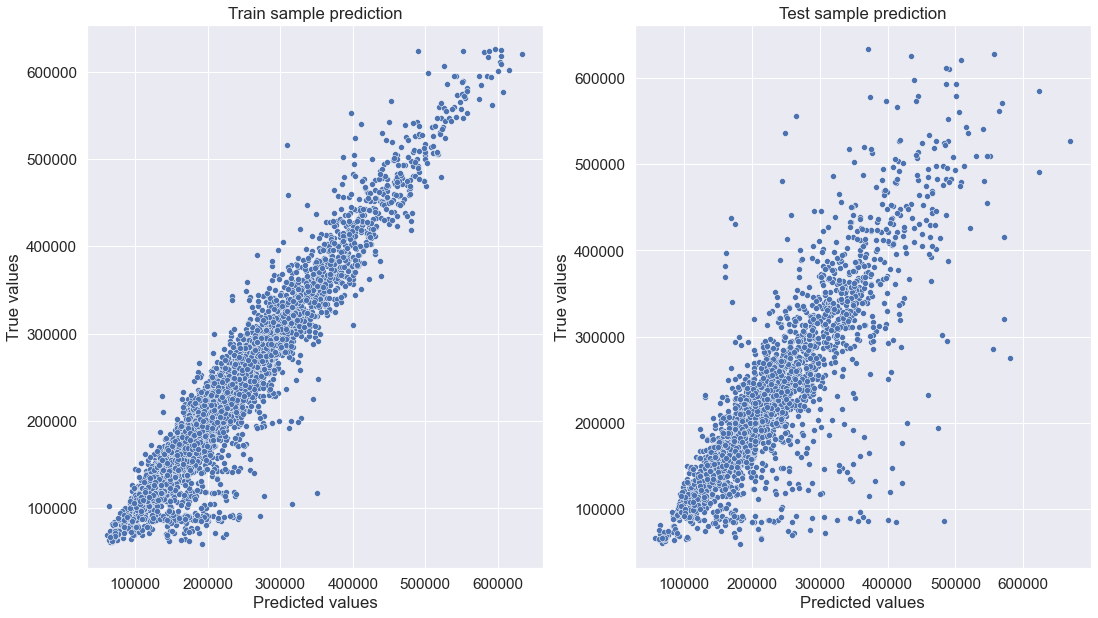

In [77]:
y_train_preds = lg_model.predict(X_train)
y_test_preds = lg_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

##  GradientBoostingRegressor

In [78]:
gb_model = GradientBoostingRegressor(loss='ls', #Функция потерь
                                     n_estimators = 350, #Количество  этапов повышения
                                     criterion='mse', #Функция измерения качества раскола
                                     min_samples_leaf=1, #Минимальное количество выборок 
                                     max_depth = 5, #Максимальная глубина
                                     random_state=21)
gb_model.fit(X_train, y_train)

GradientBoostingRegressor(criterion='mse', max_depth=5, n_estimators=350,
                          random_state=21)

#### Оценка модели

Train R2:	0.942
Test R2:	0.739


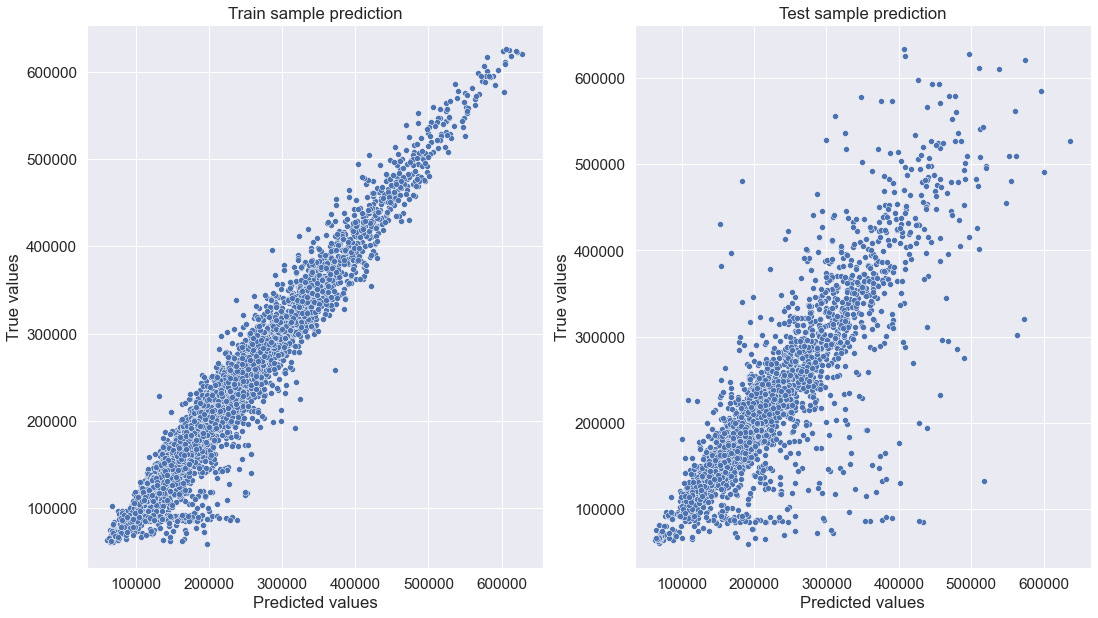

In [79]:
y_train_preds = gb_model.predict(X_train)
y_test_preds = gb_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

#### Кросс-валидация

In [80]:
cv_score = cross_val_score(gb_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=5, shuffle=True, random_state=21))
cv_score

array([0.70113468, 0.72749252, 0.74495686, 0.72382287, 0.72489649])

In [81]:
cv_score.mean()

0.7244606808613783

#### Важность признаков

In [82]:
feature_importances = pd.DataFrame(zip(X_train.columns, gb_model.feature_importances_), columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
2,Square,0.405668
9,Social_1,0.100913
11,Social_3,0.076166
10,Social_2,0.065002
1,Rooms,0.062990
0,DistrictId,0.053631
8,Ecology_1,0.049385
3,LifeSquare,0.036266
7,HouseYear,0.031929
12,Healthcare_1,0.029644


## Прогнозирование на тестовом датасете

In [83]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
submit = pd.read_csv('sample.csv')

X_train_df = train_df.drop(columns = target_name)
Y_train_df = train_df[target_name]

In [84]:
preprocessor = DataPipeline()
preprocessor.fit(X_train_df)

X_train_df = preprocessor.transform(X_train_df)
X_test_df = preprocessor.transform(test_df)

X_train_df.shape, X_test_df.shape

((10000, 24), (5000, 24))

In [85]:
X_train_df.isna().sum().sum(), X_test_df.isna().sum().sum()

(0, 0)

In [86]:
X_train_df = X_train_df[feature_names]
X_test_df = X_test_df[feature_names]

In [87]:
gb_model = GradientBoostingRegressor(loss='ls', #Функция потерь
                                     n_estimators = 350, #Количество  этапов повышения
                                     criterion='mse', #Функция измерения качества раскола
                                     min_samples_leaf=1, #Минимальное количество выборок 
                                     max_depth = 5, #Максимальная глубина
                                     random_state=21)
gb_model.fit(X_train, y_train)

GradientBoostingRegressor(criterion='mse', max_depth=5, n_estimators=350,
                          random_state=21)

In [88]:
predictions = gb_model.predict(X_test_df)
predictions

array([160774.31719603, 208356.45183419, 251749.77025168, ...,
       358564.87779629, 206399.55165365, 171696.49620511])

In [89]:
submit['Price'] = predictions

In [90]:
submit.head()

,Id,Price
0,725,160774.317196
1,15856,208356.451834
2,5480,251749.770252
3,15664,367036.275785
4,14275,142207.907850


In [91]:
submit.to_csv('submit.csv', index=False)